In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
%matplotlib inline
import swifter
from tqdm import tqdm
import utils
from sklearn.model_selection import train_test_split
from scoring import rejection90
import scoring
import xgboost as xgb

In [11]:
lengths = [10,20,40,50,60,15,14,13]

In [12]:
bins = np.digitize(lengths,[np.percentile(a,i) for i in range(10,100,10)])

In [13]:
bins

array([0, 5, 7, 8, 9, 4, 2, 1])

In [2]:
df = utils.load_train_hdf('../data/')
df.head()

ValueError: cannot set WRITEABLE flag to True of this array

In [ ]:
df_test = pd.read_hdf('../data/test_public_v2.hdf')
df_private = pd.read_hdf('../data/test_private_v2_track_1.hdf')

In [ ]:
df = df.replace(-9999,np.nan)
df_test = df_test.replace(-9999, np.nan)
df_private = df_private.replace(-9999, np.nan)
for i in range(4):
    df['MatchedHit_TYPE[{}]'.format(i)] = df['MatchedHit_TYPE[{}]'.format(i)].replace(0,np.nan)
    df_test['MatchedHit_TYPE[{}]'.format(i)] = df_test['MatchedHit_TYPE[{}]'.format(i)].replace(0,np.nan)
    df['MatchedHit_T[{}]'.format(i)] = df['MatchedHit_T[{}]'.format(i)].replace(255,np.nan)
    df_test['MatchedHit_T[{}]'.format(i)] = df_test['MatchedHit_T[{}]'.format(i)].replace(255,np.nan)
    df['MatchedHit_DT[{}]'.format(i)] = df['MatchedHit_DT[{}]'.format(i)].replace(255,np.nan)
    df_test['MatchedHit_DT[{}]'.format(i)] = df_test['MatchedHit_DT[{}]'.format(i)].replace(255,np.nan)
    
    df_private['MatchedHit_TYPE[{}]'.format(i)] = df_private['MatchedHit_TYPE[{}]'.format(i)].replace(0,np.nan)
    df_private['MatchedHit_T[{}]'.format(i)] = df_private['MatchedHit_T[{}]'.format(i)].replace(255,np.nan)
    df_private['MatchedHit_DT[{}]'.format(i)] = df_private['MatchedHit_DT[{}]'.format(i)].replace(255,np.nan)

In [ ]:
df['angle'] = np.arcsin(df['PT']/df['P'])
df_test['angle'] = np.arcsin(df_test['PT']/df_test['P'])
df['pseudorap'] = - np.log(np.tan(df['angle'] / 2))
df_test['pseudorap'] = - np.log(np.tan(df_test['angle'] / 2))
df['r'] = np.sqrt(df['angle'] ** 2 + df['pseudorap'] **2)
df_test['r'] = np.sqrt(df_test['angle'] ** 2 + df_test['pseudorap'] **2)
df['PZ'] = np.sqrt(df['P']** 2 -  df['PT']**2)
df_test['PZ'] = np.sqrt(df_test['P']** 2 -  df_test['PT']**2)

df_private['angle'] = np.arcsin(df_private['PT']/df_private['P'])
df_private['pseudorap'] = - np.log(np.tan(df_private['angle'] / 2))
df_private['r'] = np.sqrt(df_private['angle'] ** 2 + df_private['pseudorap'] **2)
df_private['PZ'] = np.sqrt(df_private['P']** 2 -  df_private['PT']**2)

In [ ]:
cols = ['MatchedHit_X[0]',
 'MatchedHit_X[1]',
 'MatchedHit_X[2]',
 'MatchedHit_X[3]',
 'MatchedHit_Y[0]',
 'MatchedHit_Y[1]',
 'MatchedHit_Y[2]',
 'MatchedHit_Y[3]',
'Lextra_X[0]',
 'Lextra_X[1]',
 'Lextra_X[2]',
 'Lextra_X[3]',
 'Lextra_Y[0]',
 'Lextra_Y[1]',
 'Lextra_Y[2]',
 'Lextra_Y[3]']
cols_arr = ['FOI_hits_X','FOI_hits_Y']
for x in cols:
    df[x] = np.abs(df[x])
    df_test[x] = np.abs(df_test[x])
    df_private[x] = np.abs(df_private[x])
for x in cols_arr:
    df[x] = [np.abs(y) for y in df[x]]
    df_test[x] = [np.abs(y) for y in df_test[x]]
    df_private[x] = [np.abs(y) for y in df_private[x]]

In [ ]:
def find_closest_hit_per_station(row):
    EMPTY_FILLER = np.nan
    result = np.empty(44, dtype=np.float32)
    closest_x_per_station = result[0:4]
    closest_y_per_station = result[4:8]
    closest_T_per_station = result[8:12]
    closest_z_per_station = result[12:16]
    closest_dx_per_station = result[16:20]
    closest_dy_per_station = result[20:24]
    closest_distance_station = result[24:28]
    normed_distance_per_stations = result[28:32]
    distance_from_origin = result[32:36]
    closest_dz = result[36:40]
    close_match_dist = result[40:44]
    total_distance = 0
    hits_count = 0
    for station in range(4):
        hits = (row["FOI_hits_S"] == station)
 
        if not hits.any():
            closest_x_per_station[station] = EMPTY_FILLER
            closest_y_per_station[station] = EMPTY_FILLER
            closest_T_per_station[station] = EMPTY_FILLER
            closest_z_per_station[station] = EMPTY_FILLER
            closest_dx_per_station[station] = EMPTY_FILLER
            closest_dy_per_station[station] = EMPTY_FILLER
            closest_distance_station[station] = EMPTY_FILLER
            normed_distance_per_stations[station] = EMPTY_FILLER
            distance_from_origin[station] = EMPTY_FILLER
            closest_dz[station] = EMPTY_FILLER
            close_match_dist[station] = EMPTY_FILLER
        else:
#             import pdb;pdb.set_trace()
            lextra = [15270, 16470, 17670, 18870]
            x_distances_2 = (row["Lextra_X[%i]" % station] - row["FOI_hits_X"][hits])**2
            y_distances_2 = (row["Lextra_Y[%i]" % station] - row["FOI_hits_Y"][hits])**2
            distances_2 = x_distances_2 + y_distances_2
            closest_hit = np.argmin(distances_2)
            closest_distance_station[station] = distances_2[closest_hit]
            distance_from_origin[station] = row["FOI_hits_Z"][hits][closest_hit]**2 + row["FOI_hits_X"][hits][closest_hit]**2 + row["FOI_hits_Y"][hits][closest_hit]**2
            closest_x_per_station[station] = x_distances_2[closest_hit]
            closest_y_per_station[station] = y_distances_2[closest_hit]
            closest_T_per_station[station] = row["FOI_hits_T"][hits][closest_hit]
            closest_z_per_station[station] = row["FOI_hits_Z"][hits][closest_hit]
            closest_dx_per_station[station] = row["FOI_hits_DX"][hits][closest_hit]
            closest_dy_per_station[station] = row["FOI_hits_DY"][hits][closest_hit]
            close_match_dist[station] = (closest_x_per_station[station] - row['MatchedHit_X[%i]' % station]) ** 2 + (closest_y_per_station[station] - row['MatchedHit_Y[%i]' % station]) ** 2
            closest_dz[station] = (closest_z_per_station[station] - lextra[station])**2
            normed_distance_per_stations[station] = x_distances_2[closest_hit] / closest_dx_per_station[station]**2 + \
                y_distances_2[closest_hit] / closest_dy_per_station[station] ** 2
            total_distance += normed_distance_per_stations[station]
            hits_count += 1
    if hits_count > 1:
        total_distance /= hits_count

    pflags = np.array([(row['P'] < 6000), (row['P'] >=  6000 and row['P'] <  10000 ), (row['P'] >= 10000), 
                       (row['P'] <= 3500), (row['P'] < 6000 and row['P'] > 3500)]).astype(np.float32)
    flags = np.diag([1,1,1,1])[row["FOI_hits_S"]].sum(0).clip(max = 1).astype(np.float32)
    ismuon1 = flags[0] * flags[1] * (row['P'] < 6000)
    ismuon2 = flags[0] * flags[1] * (flags[2] + flags[3]).clip(max=1) * (row['P'] >=  6000 and row['P'] <  10000 )
    ismuon3 = flags[0] * flags[1] * flags[2] * flags[3] * (row['P'] >= 10000)
    ismuon = (ismuon1 + ismuon2 + ismuon3).clip(max=1)
    isloose1 = flags[0] * flags[1] * (row['P'] <= 3500)
    isloose2 = ((flags[0] + flags[1] + flags[2]) >= 2) * (row['P'] < 6000 and row['P'] > 3500 )
    isloose3 = ((flags[0] + flags[1] + flags[2] + flags[3]) >= 3) * (row['P'] >= 10000 )
    isloose = (isloose1 + isloose2 + isloose3).clip(max = 1)
    tight_hits = [x for i,x in enumerate(row["FOI_hits_S"]) if row['MatchedHit_TYPE[%i]' % x] == 2]
    if tight_hits:
        tight_flags = np.diag([1,1,1,1])[tight_hits].sum(0).clip(max = 1)
        istight1 = tight_flags[0] * tight_flags[1] * (row['P'] < 6000)
        istight2 = tight_flags[0] * tight_flags[1] * (tight_flags[2] + tight_flags[3]).clip(max=1) * (row['P'] >=  6000 and row['P'] <  10000 )
        istight3 = tight_flags[0] * tight_flags[1] * tight_flags[2] * tight_flags[3] * (row['P'] >= 10000)
        istight = (istight1 + istight2 + istight3).clip(max=1)
    else:
        istight = 0
    result = np.concatenate((result,pflags, flags,np.array([ismuon,isloose,istight,hits_count,total_distance])))
    return result

In [ ]:
find_closest_hit_per_station(df.iloc[0])

In [ ]:
closest_hits_features = df.swifter.apply(
    find_closest_hit_per_station, result_type="expand", axis=1)
closest_hits_features_test = df_test.swifter.apply(
    find_closest_hit_per_station, result_type="expand", axis=1)
closest_hits_features_private = df_private.swifter.apply(
    find_closest_hit_per_station, result_type="expand", axis=1)

In [ ]:
X = pd.concat(
    [df.loc[:, utils.SIMPLE_FEATURE_COLUMNS + ['angle','pseudorap','r','PZ']],
     closest_hits_features], axis=1)
X_pred = pd.concat(
    [df_test.loc[:, utils.SIMPLE_FEATURE_COLUMNS + ['angle','pseudorap','r','PZ']], closest_hits_features_test],
    axis=1)
X_private = pd.concat(
    [df_private.loc[:, utils.SIMPLE_FEATURE_COLUMNS + ['angle','pseudorap','r','PZ']], closest_hits_features_private],
    axis=1)

In [ ]:
X.shape,X_pred.shape,X_private.shape

In [ ]:
# X = df[SIMPLE_FEATURE_COLUMNS]
y = df['label']

In [ ]:
# binned_weights = np.digitize(df['weight'],bins = [np.percentile(df['weight'][df['particle_type'] == 0],i) for i in range(10,100,10)])*(df['particle_type'] == 0) +\
# (np.digitize(df['weight'],bins = [np.percentile(df['weight'][df['particle_type'] == 1],i) for i in range(10,100,10)])+10)*(df['particle_type'] == 1) +\
# (np.digitize(df['weight'],bins = [np.percentile(df['weight'][df['particle_type'] == 2],i) for i in range(10,100,10)])+20)*(df['particle_type'] == 2)

In [ ]:
# plt.hist(binned_weights)

In [ ]:
old_coluns = X.columns

In [ ]:
import xgboost as xgb

In [ ]:
new_columns = [str(x).replace('[','').replace(']','') for x in X.columns]
X.columns = new_columns
X_pred.columns = new_columns
X_private.columns = new_columns

In [3]:
pred_dataset = xgb.DMatrix(X_pred)
dataset = xgb.DMatrix(X, label = y, weight=df.weight.values)
private_dataset = xgb.DMatrix(X_private)

NameError: name 'xgb' is not defined

In [80]:

parameters = {
              'booster' : 'gbtree',
              'max_depth' : 6,
              'gamma' : 1.,
              'eta' : 0.05,
              'objective' : 'binary:logistic',
              'nthread' : 80,
              'silent' : True,
#               'eval_metric': 'rej90',
              'subsample' : 0.8,
              'colsample_bytree' : 0.7,
#               'min_child_weight' : 3,
#               'max_delta_step' : 1,
#               'seed' : 42
                'alpha':0.1,
#                 'lambda':1,
              }

In [81]:
#gamma

In [82]:
def feval(preds, data):
    return  ('rej90',scoring.get_rejection_at_efficiency(data.get_label(),
                                                         preds, 0.9, data.get_weight()))

In [83]:
# xgb.cv(parameters,dataset,early_stopping_rounds=100,nfold=5, stratified=True,
#                       verbose_eval=10, num_boost_round=10000, feval = feval,maximize=True )

In [ ]:
predictions = []
auc = []
models = []
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits = 5, random_state=43)
for train_index, test_index in tqdm(list(kfold.split(X,y))):
    X_train,y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    w_train, w_test  = df.weight.iloc[train_index].values, df.weight.iloc[test_index].values
    train_dataset = xgb.DMatrix(X_train, label = y_train, weight=w_train)
    test_dataset = xgb.DMatrix(X_test, label = y_test,weight=w_test)
    model = xgb.train(parameters, train_dataset, evals=[(train_dataset,'train'), (test_dataset, 'test')],early_stopping_rounds=100,
                      verbose_eval=10, num_boost_round=10000, feval = feval,maximize=True)
    auc.append(model.best_score)
    predictions.append(model.predict(pred_dataset))
    models.append(model)













  0%|          | 0/5 [00:00<?, ?it/s]

[13:11:05] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	train-error:0.199744	test-error:0.195078	train-rej90:0.695476	test-rej90:0.702914
Multiple eval metrics have been passed: 'test-rej90' will be used for early stopping.

Will train until test-rej90 hasn't improved in 100 rounds.
[10]	train-error:0.196028	test-error:0.197382	train-rej90:0.737742	test-rej90:0.746015
[20]	train-error:0.191815	test-error:0.198029	train-rej90:0.743415	test-rej90:0.749959
[30]	train-error:0.183698	test-error:0.189776	train-rej90:0.752957	test-rej90:0.754963
[40]	train-error:0.181875	test-error:0.187903	train-rej90:0.760751	test-rej90:0.76084
[50]	train-error:0.178199	test-error:0.185329	train-rej90:0.765981	test-rej90:0.761397
[60]	train-error:0.174906	test-error:0.184276	train-rej90:0.773558	test-rej90:0.767831
[70]	train-error:0.170983	test-error:0.181265	train-rej90:0.781884	test-r













 20%|██        | 1/5 [1:03:47<4:15:11, 3827.86s/it]

[14:14:54] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	train-error:0.20564	test-error:0.209294	train-rej90:0.668237	test-rej90:0.657905
Multiple eval metrics have been passed: 'test-rej90' will be used for early stopping.

Will train until test-rej90 hasn't improved in 100 rounds.
[10]	train-error:0.207759	test-error:0.215705	train-rej90:0.736183	test-rej90:0.719779
[20]	train-error:0.186394	test-error:0.191043	train-rej90:0.749961	test-rej90:0.738291
[30]	train-error:0.183408	test-error:0.187104	train-rej90:0.757781	test-rej90:0.745838
[40]	train-error:0.180814	test-error:0.184668	train-rej90:0.764495	test-rej90:0.747695
[50]	train-error:0.178487	test-error:0.183202	train-rej90:0.771054	test-rej90:0.753174
[60]	train-error:0.176454	test-error:0.183197	train-rej90:0.775766	test-rej90:0.754954
[70]	train-error:0.173959	test-error:0.183181	train-rej90:0.780599	test-r













 40%|████      | 2/5 [2:07:35<3:11:23, 3827.75s/it]

[15:18:44] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	train-error:0.217535	test-error:0.22743	train-rej90:0.646482	test-rej90:0.631015
Multiple eval metrics have been passed: 'test-rej90' will be used for early stopping.

Will train until test-rej90 hasn't improved in 100 rounds.
[10]	train-error:0.192605	test-error:0.199877	train-rej90:0.736695	test-rej90:0.717021
[20]	train-error:0.186732	test-error:0.197429	train-rej90:0.752241	test-rej90:0.731427
[30]	train-error:0.181625	test-error:0.190246	train-rej90:0.758839	test-rej90:0.740403
[40]	train-error:0.18092	test-error:0.18821	train-rej90:0.765369	test-rej90:0.744801
[50]	train-error:0.17771	test-error:0.186115	train-rej90:0.771754	test-rej90:0.749599
[60]	train-error:0.174415	test-error:0.185126	train-rej90:0.776585	test-rej90:0.754657
[70]	train-error:0.17179	test-error:0.183984	train-rej90:0.783656	test-rej90













 60%|██████    | 3/5 [2:51:32<1:55:41, 3470.64s/it]

[16:02:39] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	train-error:0.219063	test-error:0.224334	train-rej90:0.645483	test-rej90:0.634863
Multiple eval metrics have been passed: 'test-rej90' will be used for early stopping.

Will train until test-rej90 hasn't improved in 100 rounds.
[10]	train-error:0.197194	test-error:0.204281	train-rej90:0.739318	test-rej90:0.724353
[20]	train-error:0.188928	test-error:0.194584	train-rej90:0.747134	test-rej90:0.733929
[30]	train-error:0.185277	test-error:0.19141	train-rej90:0.754619	test-rej90:0.741683
[40]	train-error:0.18067	test-error:0.189927	train-rej90:0.762028	test-rej90:0.747282
[50]	train-error:0.178261	test-error:0.185718	train-rej90:0.769471	test-rej90:0.755965
[60]	train-error:0.175673	test-error:0.18484	train-rej90:0.776043	test-rej90:0.757734
[70]	train-error:0.172744	test-error:0.184152	train-rej90:0.782549	test-rej

In [94]:
import pickle
with open('model_final','wb+') as f:
    pickle.dump(models,f )

In [117]:
# y_pred = np.mean(predictions,0)
# pd.DataFrame(data={"prediction": y_pred}, index=X_pred.index).to_csv(
#     "submission_xgboost_final.csv", index_label=utils.ID_COLUMN)

In [119]:
# import pickle
# with open('model_final','rb') as f:
#     models = pickle.load(f )

In [122]:
private_predictions = []
for model in models:
    private_predictions.append(model.predict(private_dataset))
y_private = np.mean(private_predictions,0)

In [123]:
pd.DataFrame(data={"prediction": y_private}, index=X_private.index).to_csv(
    "submission_xgboost_private.csv", index_label=utils.ID_COLUMN)

In [124]:
X_private.shape

(1452188, 127)

(array([ 84920.,  21781.,  27050.,  47243.,  95563., 185391., 249604.,
        222270., 223467., 294899.]),
 array([5.6924888e-05, 9.9931978e-02, 1.9980703e-01, 2.9968208e-01,
        3.9955711e-01, 4.9943218e-01, 5.9930724e-01, 6.9918227e-01,
        7.9905730e-01, 8.9893240e-01, 9.9880743e-01], dtype=float32),
 <a list of 10 Patch objects>)

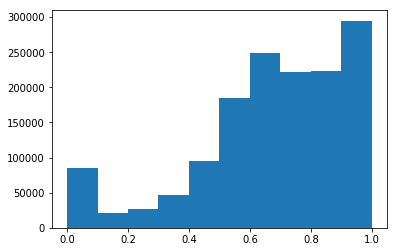

In [126]:
# plt.hist(y_private)

(array([ 42187.,  10853.,  13204.,  23620.,  47948.,  93344., 124831.,
        111196., 111405., 147507.]),
 array([1.0431225e-04, 9.9999756e-02, 1.9989519e-01, 2.9979062e-01,
        3.9968607e-01, 4.9958152e-01, 5.9947693e-01, 6.9937241e-01,
        7.9926783e-01, 8.9916331e-01, 9.9905872e-01], dtype=float32),
 <a list of 10 Patch objects>)

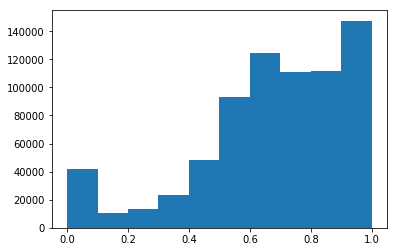

In [127]:
# plt.hist(y_pred)

In [129]:
# y_pred.shape,y_private.shape

((726095,), (1452188,))